<a href="https://colab.research.google.com/github/plaban1981/HACKEREARTH/blob/master/Novratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from google drive

In [86]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

## Problem Statement 

Predict if a server will be hacked 

#### DATA

**Features :**

* INCIDENT_ID - Unique Identifier of an INCIDENT LOG
* DATE        - DATE of incident occurrence
* X1~X15      - Anonymous logging parameters

**Label:**

MULTIPLE_OFFENSE  {0: NO, 1: YES}

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score,recall_score
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
#
%matplotlib inline


In [0]:
train = pd.read_csv('/content/drive/My Drive/Dataset/Train.csv')
test = pd.read_csv('/content/drive/My Drive/Dataset/Test.csv')

In [0]:
sub = pd.read_csv('/content/drive/My Drive/Dataset/Test.csv')

In [38]:
train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


## Data Statistics

In [12]:
train.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747,0.955231
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834,0.206800
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000,1.000000


# Check for Null Values

In [5]:
train.isnull().sum()[train.isnull().sum() > 0]

X_12    182
dtype: int64

In [6]:
test.isnull().sum()[test.isnull().sum() > 0]

X_12    127
dtype: int64

## Impute missing values

In [0]:
train['X_12'] = train['X_12'].fillna(train['X_12'].median())
test['X_12'] = test['X_12'].fillna(test['X_12'].median())

## Convvert into Date format

In [0]:
train['DATE'] =pd.to_datetime(train['DATE'])
test['DATE'] =pd.to_datetime(test['DATE'])

## create new date based features

In [0]:
train['DAY'] = train['DATE'].dt.day
train['MONTH'] = train['DATE'].dt.month
train['WEEK_DAY'] = train['DATE'].dt.weekday
train['YEAR'] = train['DATE'].dt.year

In [0]:
test['DAY'] = test['DATE'].dt.day
test['MONTH'] = test['DATE'].dt.month
test['WEEK_DAY'] = test['DATE'].dt.weekday
test['YEAR'] = test['DATE'].dt.year

In [46]:
train.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
       'MULTIPLE_OFFENSE', 'DAY', 'MONTH', 'WEEK_DAY', 'YEAR'],
      dtype='object')

In [0]:
train.drop(['INCIDENT_ID', 'DATE'],axis=1,inplace=True)
test.drop(['INCIDENT_ID', 'DATE'],axis=1,inplace=True)

# Visualize Label

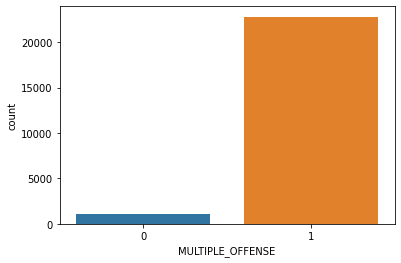

In [20]:
sns.countplot(train['MULTIPLE_OFFENSE'])

#### Note Data is highly imbalanced

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c839b8da0>,
      dtype=object)

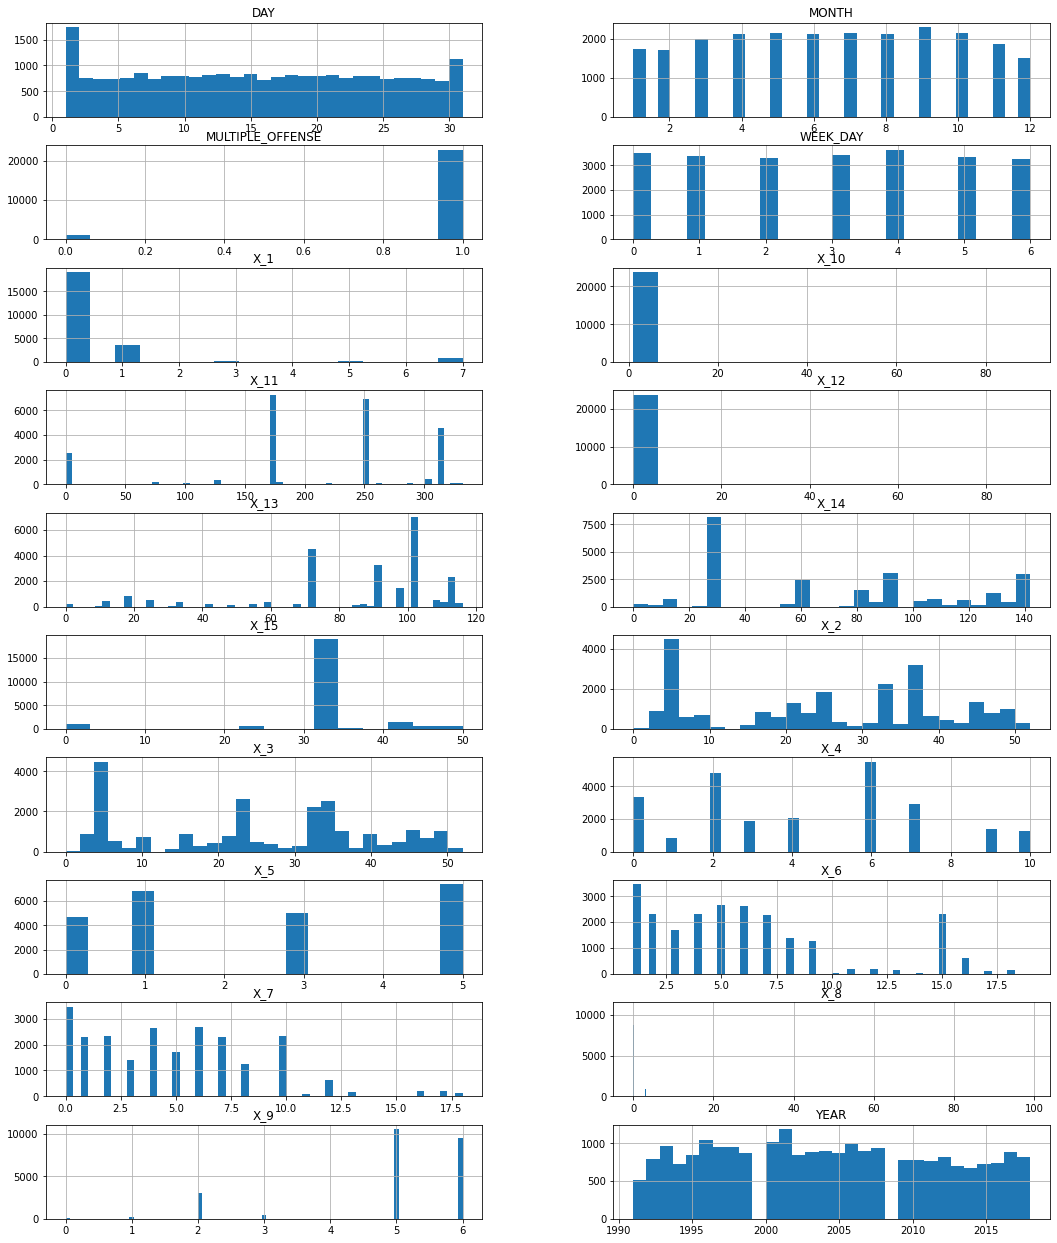

In [57]:
train.hist(bins='auto',figsize=(18, 22), layout=(10, 2))

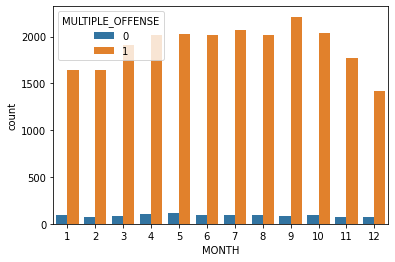

In [21]:
sns.countplot(x='MONTH',data=train,hue='MULTIPLE_OFFENSE')

*Now Using A baseline model and Feature Importances we will see which features gets us the a good cross validation score, the features are mentioned as above which need to be dropped*

# Cross Validation with LightGBM classifiers 

In [52]:
cv = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
score_avg = []
X = train.drop('MULTIPLE_OFFENSE',axis=1)
y = train['MULTIPLE_OFFENSE']
for (train_ind, test_ind), i in zip(cv.split(X,y), range(10)):
    m = lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=100,
                       colsample_bytree=0.5,num_leaves=70,min_child_samples=20,lambda_l1=1.6,lambda_l2=4) 
    m.fit(X.iloc[train_ind], y.iloc[train_ind])
    score_avg.append(recall_score(y_pred=m.predict(X.iloc[test_ind]),y_true=y.iloc[test_ind]))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

          0
0  1.000000
1  1.000000
2  1.000000
3  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  1.000000
9  0.999561
0.999956121105748


# Cross Validation with RandomForestClassifier

In [65]:
rf = RandomForestClassifier(random_state=0, max_depth=13, n_estimators=100, max_features=None, n_jobs=4, class_weight={0:0.6, 1:0.4})
results_rf = pd.DataFrame(columns=['training_score', 'test_score'])
score_avg = []
X = train.drop('MULTIPLE_OFFENSE',axis=1)
y = train['MULTIPLE_OFFENSE']
for (train_ind, test_ind), i in zip(cv.split(X,y), range(10)):
    rf = RandomForestClassifier(random_state=0, max_depth=13, n_estimators=100, max_features=None, n_jobs=4, class_weight={0:0.6, 1:0.4})
    rf.fit(X.iloc[train_ind], y.iloc[train_ind])
    score_avg.append(recall_score(y_pred=m.predict(X.iloc[test_ind]),y_true=y.iloc[test_ind]))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

          0
0  1.000000
1  1.000000
2  1.000000
3  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  1.000000
9  0.999561
0.999956121105748


# Make Predictions on test _data

In [0]:
test_data = test[X.columns]

In [0]:
preds_rf = rf.predict_proba(test_data)
preds_lgb = m.predict_proba(test_data)

# Using Weighted Ensembling - since imbalanced dataset

In [0]:
test['MULTIPLE_OFFENSE'] = preds_rf[:,1]*0.4 + preds_lgb[:,1]*0.6

In [0]:
test['MULTIPLE_OFFENSE']  = test['MULTIPLE_OFFENSE'] .apply(lambda x : 1 if x > 0.5 else 0)

In [76]:
test.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,DAY,MONTH,WEEK_DAY,YEAR,MULTIPLE_OFFENSE
0,0,30,35,7,3,6,4,0,5,1,174,1.0,72,119,23,1,2,3,2018,1
1,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,5,3,4,2004,1
2,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,27,1,5,2018,1
3,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,18,8,4,2006,1
4,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,31,10,0,2011,1


## Visualize the predictions madce on test data

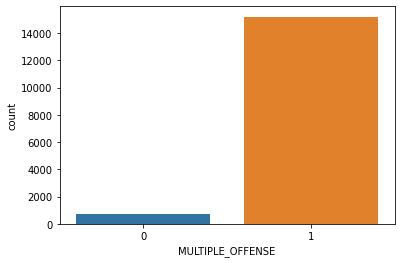

In [77]:
sns.countplot(test['MULTIPLE_OFFENSE'])

In [82]:
test.shape,sub.shape

((15903, 20), (15903, 17))

### Format the data for predictions

In [0]:
sub['MULTIPLE_OFFENSE'] = preds_rf[:,1]*0.4 + preds_lgb[:,1]*0.6
sub['MULTIPLE_OFFENSE']  = test['MULTIPLE_OFFENSE'] .apply(lambda x : 1 if x > 0.5 else 0) ## threshold > 0.5 belongs to class 1

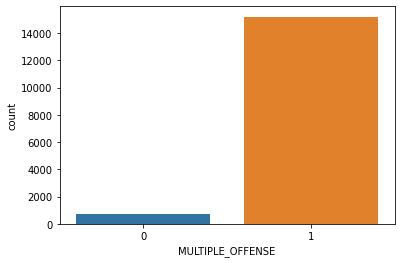

In [84]:
sns.countplot(sub['MULTIPLE_OFFENSE'])

## Download predictions to a csv file

In [0]:
sub[['INCIDENT_ID','MULTIPLE_OFFENSE']].to_csv('sub_wght_ensemble.csv',index=False)